In [4]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1uXedNmn-zjJGL4jW2ooP0N2hv83bUcSu' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1uXedNmn-zjJGL4jW2ooP0N2hv83bUcSu" -O images.zip && rm -rf /tmp/cookies.txt

--2021-08-26 12:07:24--  https://docs.google.com/uc?export=download&confirm=9d3C&id=1uXedNmn-zjJGL4jW2ooP0N2hv83bUcSu
Resolving docs.google.com (docs.google.com)... 172.217.2.110, 2607:f8b0:4004:835::200e
Connecting to docs.google.com (docs.google.com)|172.217.2.110|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-70-docs.googleusercontent.com/docs/securesc/utqms0bi2a6sl4cpvvf1qr79re0cuhn3/noebna64t5k4hph3emqqbk662uvv68bt/1629979575000/02667485512418348371/11058324414197122535Z/1uXedNmn-zjJGL4jW2ooP0N2hv83bUcSu?e=download [following]
--2021-08-26 12:07:24--  https://doc-0c-70-docs.googleusercontent.com/docs/securesc/utqms0bi2a6sl4cpvvf1qr79re0cuhn3/noebna64t5k4hph3emqqbk662uvv68bt/1629979575000/02667485512418348371/11058324414197122535Z/1uXedNmn-zjJGL4jW2ooP0N2hv83bUcSu?e=download
Resolving doc-0c-70-docs.googleusercontent.com (doc-0c-70-docs.googleusercontent.com)... 142.251.33.193, 2607:f8b0:4004:837::2001
Connecting to doc-0c-

In [5]:
!unzip images.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/d80ead8703.png   
  inflating: images/b012e9ebb0.png   
  inflating: images/d3034e7a60.png   
  inflating: images/ae2ef70d51.png   
  inflating: images/1af44a9db0.png   
  inflating: images/41cfd4b320.png   
  inflating: images/853e89d0d3.png   
  inflating: images/2a484baa26.png   
  inflating: images/92e617896e.png   
  inflating: images/b70f0ab0c2.png   
  inflating: images/e8757626a1.png   
  inflating: images/6a3d92ce59.png   
  inflating: images/127ef4105f.png   
  inflating: images/d21012f5c1.png   
  inflating: images/1cb9549d2c.png   
  inflating: images/e030bdae65.png   
  inflating: images/0cf7155eb6.png   
  inflating: images/badb3ea766.png   
  inflating: images/9bd58061d6.png   
  inflating: images/2b1e71c2a3.png   
  inflating: images/28d42de29f.png   
  inflating: images/10833853b3.png   
  inflating: images/ef13247eed.png   
  inflating: images/bce104494c.png   
  inflating: images/c8ce151a18.png   

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from random import *
import os
from tensorflow.keras import Model, Input
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Dense, Dropout, Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, BatchNormalization, Activation, Add
from tensorflow.keras.layers import concatenate
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
import tensorflow as tf

In [7]:
TRAIN_IMAGE_DIR = '/content/images'
TRAIN_MASK_DIR = '/content/masks'

#listdir metoda (iz os modula koji obezbeđuje funkcije za intereakciju sa operativnim sistemom) vraca nazive fotografija 
#koje se nalaze u okviru direktorijuma koji je prosleđen kao parametar metode
train_d = os.listdir(TRAIN_IMAGE_DIR)

In [8]:

x = [np.array(cv2.imread(TRAIN_IMAGE_DIR + "/{}".format(p), cv2.IMREAD_GRAYSCALE)) for p in train_d]
x = np.array(x)/255

y = [np.array(cv2.imread(TRAIN_MASK_DIR + "/{}".format(p), cv2.IMREAD_GRAYSCALE)) for p in train_d]
y = np.array(y)/255

print(x.shape, y.shape)

(4000, 101, 101) (4000, 101, 101)


In [9]:
def plotImages(file1, file2, k, alpha = 0.4):
  fig, ax = plt.subplots(nrows=k, ncols=k, figsize=(15,15))
  for i in range(k):
    for j in range(k):
      ind = randint(0, file1.shape[0]-1)
      ax[i,j].imshow(file1[ind], cmap='Greys')
      ax[i,j].imshow(file2[ind], cmap='Reds', alpha = alpha)
      ax[i,j].set_axis_off()
  fig.subplots_adjust(wspace = -0.30, hspace= 0.05)
  return(fig)

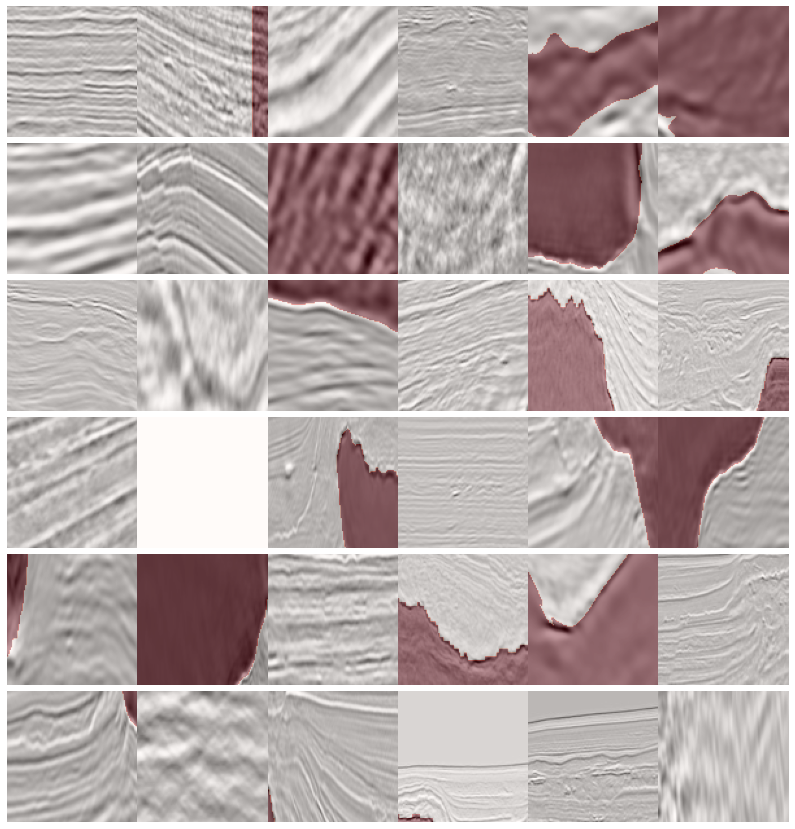

In [10]:
fig = plotImages(x,y,k=6)

In [11]:
x_train,x_validation,y_train,y_validation = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=50)

In [12]:
print("x_train shape:",x_train.shape)
print("x_validation shape:",x_validation.shape)
print("y_train shape:",y_train.shape)
print("y_validation shape:",y_validation.shape)

x_train shape: (3200, 101, 101)
x_validation shape: (800, 101, 101)
y_train shape: (3200, 101, 101)
y_validation shape: (800, 101, 101)


In [13]:
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

#definisanje konvolucionog bloka
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation==True: x = BatchActivate(x)
    return x

#definisanje residual (identity) bloka
def residual_block(blockInput, num_filters=16, batch_activate=False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3))
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate: x = BatchActivate(x)
    return x

In [14]:
def build_model(input_layer, start_neurons, DropoutRatio=0.5):
    # 101 -> 50
    conv1 = Conv2D(start_neurons*1, (3,3), activation=None, padding='same')(input_layer)
    conv1 = residual_block(conv1, start_neurons*1)
    conv1 = residual_block(conv1, start_neurons*1, True)
    pool1 = MaxPooling2D((2,2))(conv1)
    pool1 = Dropout(DropoutRatio/2)(pool1)
    print("conv1", conv1)
    # 50 -> 25
    conv2 = Conv2D(start_neurons*2, (3,3), activation=None, padding='same')(pool1)
    conv2 = residual_block(conv2, start_neurons*2)
    conv2 = residual_block(conv2, start_neurons*2, True)
    pool2 = MaxPooling2D((2,2))(conv2)
    pool2 = Dropout(DropoutRatio)(pool2)
    print("conv2", conv2)
    # 25 -> 12
    conv3 = Conv2D(start_neurons*4, (3,3), activation=None, padding='same')(pool2)
    conv3 = residual_block(conv3, start_neurons*4)
    conv3 = residual_block(conv3, start_neurons*4, True)
    pool3 = MaxPooling2D((2,2))(conv3)
    pool3 = Dropout(DropoutRatio)(pool3)
    print("conv3", conv3)
    # 12 -> 6
    conv4 = Conv2D(start_neurons*8, (3,3), activation=None, padding='same')(pool3)
    conv4 = residual_block(conv4, start_neurons*8)
    conv4 = residual_block(conv4, start_neurons*8, True)
    pool4 = MaxPooling2D((2,2))(conv4)
    pool4 = Dropout(DropoutRatio)(pool4)
    print("conv4", conv4)
    # Middle
    convm = Conv2D(start_neurons*16, (3,3), activation=None, padding='same')(pool4)
    convm = residual_block(convm, start_neurons*16)
    convm = residual_block(convm, start_neurons*16, True)
    print("convm", convm)
    # 6 -> 12
    deconv4 = Conv2DTranspose(start_neurons*8, (3,3), strides=(2,2), padding='same')(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(DropoutRatio)(uconv4)
    
    uconv4 = Conv2D(start_neurons*8, (3,3), activation=None, padding='same')(uconv4)
    uconv4 = residual_block(uconv4, start_neurons*8)
    uconv4 = residual_block(uconv4, start_neurons*8, True)
    print("conv4", uconv4)
    # 12 -> 25
    deconv3 = Conv2DTranspose(start_neurons*4, (3,3), strides=(2,2), padding='valid')(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(DropoutRatio)(uconv3)
    
    uconv3 = Conv2D(start_neurons*4, (3,3), activation=None, padding='same')(uconv3)
    uconv3 = residual_block(uconv3, start_neurons*4)
    uconv3 = residual_block(uconv3, start_neurons*4, True)
    print("conv3", uconv3)
    # 25 -> 50
    deconv2 = Conv2DTranspose(start_neurons*2, (3,3), strides=(2,2), padding='same')(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(DropoutRatio)(uconv2)
    
    uconv2 = Conv2D(start_neurons*2, (3,3), activation=None, padding='same')(uconv2)
    uconv2 = residual_block(uconv2, start_neurons*2)
    uconv2 = residual_block(uconv2, start_neurons*2, True)
    print("conv2", uconv2)
    # 50 -> 101
    deconv1 = Conv2DTranspose(start_neurons*1, (3,3), strides=(2,2), padding='valid')(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(DropoutRatio)(uconv1)
    
    uconv1 = Conv2D(start_neurons*1, (3,3), activation=None, padding='same')(uconv1)
    uconv1 = residual_block(uconv1, start_neurons*1)
    uconv1 = residual_block(uconv1, start_neurons*1, True)
    
    output_layer_noActi = Conv2D(1, (1,1), padding='same', activation=None)(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)
    
    return output_layer

In [15]:
input_layer = Input((101, 101, 1))
output_layer = build_model(input_layer, 32,0.5)

model = Model(input_layer, output_layer)
model.summary()

conv1 KerasTensor(type_spec=TensorSpec(shape=(None, 101, 101, 32), dtype=tf.float32, name=None), name='activation_4/Relu:0', description="created by layer 'activation_4'")
conv2 KerasTensor(type_spec=TensorSpec(shape=(None, 50, 50, 64), dtype=tf.float32, name=None), name='activation_9/Relu:0', description="created by layer 'activation_9'")
conv3 KerasTensor(type_spec=TensorSpec(shape=(None, 25, 25, 128), dtype=tf.float32, name=None), name='activation_14/Relu:0', description="created by layer 'activation_14'")
conv4 KerasTensor(type_spec=TensorSpec(shape=(None, 12, 12, 256), dtype=tf.float32, name=None), name='activation_19/Relu:0', description="created by layer 'activation_19'")
convm KerasTensor(type_spec=TensorSpec(shape=(None, 6, 6, 512), dtype=tf.float32, name=None), name='activation_24/Relu:0', description="created by layer 'activation_24'")
conv4 KerasTensor(type_spec=TensorSpec(shape=(None, 12, 12, 256), dtype=tf.float32, name=None), name='activation_29/Relu:0', description="cre

In [16]:
# binary cross entropy izračunava loss između stvarnih i predviđenih vrednosti
# Adam je optimizator koji koristi Adam optimizacioni algoritam koji se može koristiti 
# umesto klasične stohastičke gradiant descent procedure za prilagođavanje stope ućenja (ažuriranje težina veza i minimizaciju greške)  
model.compile(loss = "binary_crossentropy", optimizer= "adam", metrics= ["accuracy"])

In [17]:
# Early stopping je tehnika koja se koristi da prekine obuku modela u slučaju da željeni (prosleđeni) parametri prestanu da se poboljšavaju
# Na kraju svake epohe se proverava da li prosleđena metrika (u ovom slucaju tacnost na validacionom skupu - val_accuracy) raste za minimalnu vrednost od 0.001
# i ukoliko to nije slučaj ni nakon 10 epoha (patience = 10) prekinuće se treniranje modela, a sve u cilju kako bi se smanjio overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.001, patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_LR = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, min_lr=0.00000005, verbose=1)

history = model.fit(x_train, y_train, validation_data=(x_validation,y_validation), epochs = 15, batch_size = 128, callbacks = [early_stopping, model_checkpoint, reduce_LR])

Epoch 1/15
25/25 [==============================] - 2161s 86s/step - loss: 0.6452 - accuracy: 0.6313 - val_loss: 11.2741 - val_accuracy: 0.2596

Epoch 00001: val_accuracy improved from -inf to 0.25957, saving model to ./keras.model
INFO:tensorflow:Assets written to: ./keras.model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
25/25 [==============================] - 2161s 87s/step - loss: 0.4407 - accuracy: 0.8333 - val_loss: 5.6554 - val_accuracy: 0.3115

Epoch 00002: val_accuracy improved from 0.25957 to 0.31147, saving model to ./keras.model
INFO:tensorflow:Assets written to: ./keras.model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/15
25/25 [==============================] - 2163s 87s/step - loss: 0.3957 - accuracy: 0.8531 - val_loss: 1.1073 - val_accuracy: 0.4056

Epoch 00003: val_accuracy improved from 0.31147 to 0.40562, saving model to ./keras.model
INFO:tensorflow:Assets written to: ./keras.model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 4/15
25/25 [==============================] - 2165s 87s/step - loss: 0.3653 - accuracy: 0.8670 - val_loss: 2.4654 - val_accuracy: 0.6957

Epoch 00004: val_accuracy improved from 0.40562 to 0.69575, saving model to ./keras.model
INFO:tensorflow:Assets written to: ./keras.model/assets


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/15
25/25 [==============================] - 2171s 87s/step - loss: 0.3269 - accuracy: 0.8834 - val_loss: 2.1019 - val_accuracy: 0.6262

Epoch 00005: val_accuracy did not improve from 0.69575
Epoch 6/15
25/25 [==============================] - 2165s 87s/step - loss: 0.3010 - accuracy: 0.8932 - val_loss: 1.8866 - val_accuracy: 0.6558

Epoch 00006: val_accuracy did not improve from 0.69575
Epoch 7/15
25/25 [==============================] - 2167s 87s/step - loss: 0.2912 - accuracy: 0.8941 - val_loss: 1.8792 - val_accuracy: 0.3831

Epoch 00007: val_accuracy did not improve from 0.69575
Epoch 8/15
25/25 [==============================] - 2204s 88s/step - loss: 0.2752 - accuracy: 0.9003 - val_loss: 1.4475 - val_accuracy: 0.5392

Epoch 00008: val_accuracy did not improve from 0.69575
Epoch 9/15
25/25 [==============================] - 2200s 88s/step - loss: 0.2648 - accuracy: 0.9003 - val_loss: 1.3850 - val_accuracy: 0.3793

Epoch 00009: val_accuracy did not improve from 0.69575

Epoc

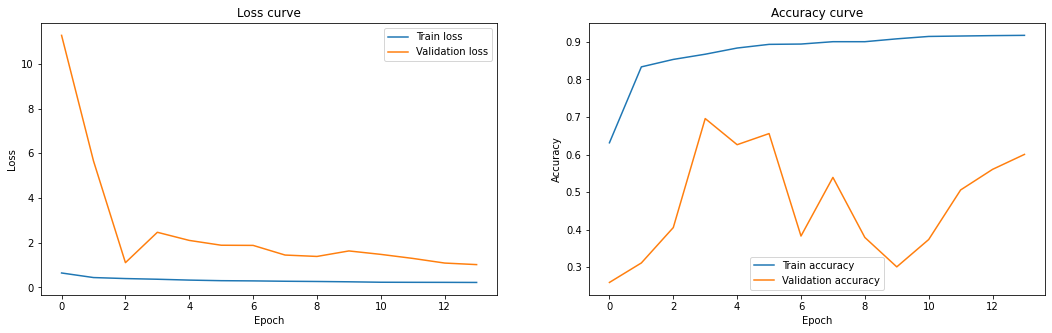

In [18]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(18, 5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.set_xlabel("Epoch")
ax_loss.set_ylabel("Loss")
ax_loss.set_title("Loss curve")
ax_loss.legend()
ax_acc.plot(history.epoch, history.history["accuracy"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
ax_acc.set_xlabel("Epoch")
ax_acc.set_ylabel("Accuracy")
ax_acc.set_title("Accuracy curve")
ax_acc.legend()

In [19]:
result = model.evaluate(x_validation, y_validation)

loss = result[0]
accuracy = result[1]
print(f"[+] Accuracy: {accuracy*100:.2f}%")

25/25 [==============================] - 123s 5s/step - loss: 1.0198 - accuracy: 0.6004
[+] Accuracy: 60.04%


Predikcija na validacionom setu


In [20]:
pred_validation = model.predict(x_validation)
pred_validation = pred_validation[:,:,:,0]
print(x_validation.shape, y_validation.shape)

(800, 101, 101) (800, 101, 101)


In [21]:
def plotValidationImages(file1, file2, file3, k, alpha1, alpha2):
  fig, ax = plt.subplots(nrows=k, ncols=k, figsize=(15,15))
  for i in range(k):
    for j in range(k):
      ind = randint(0, file1.shape[0]-1)
      ax[i,j].imshow(file1[ind], cmap='Greys')
      ax[i,j].imshow(file2[ind], cmap='Reds', alpha = alpha1)
      ax[i,j].imshow(file3[ind], cmap='Greens', alpha = alpha2)
      ax[i,j].set_axis_off()
  fig.subplots_adjust(wspace = -0.30, hspace= 0.05)
  plt.suptitle("Crvena: so    Zelena: predikcija")
  return(fig)

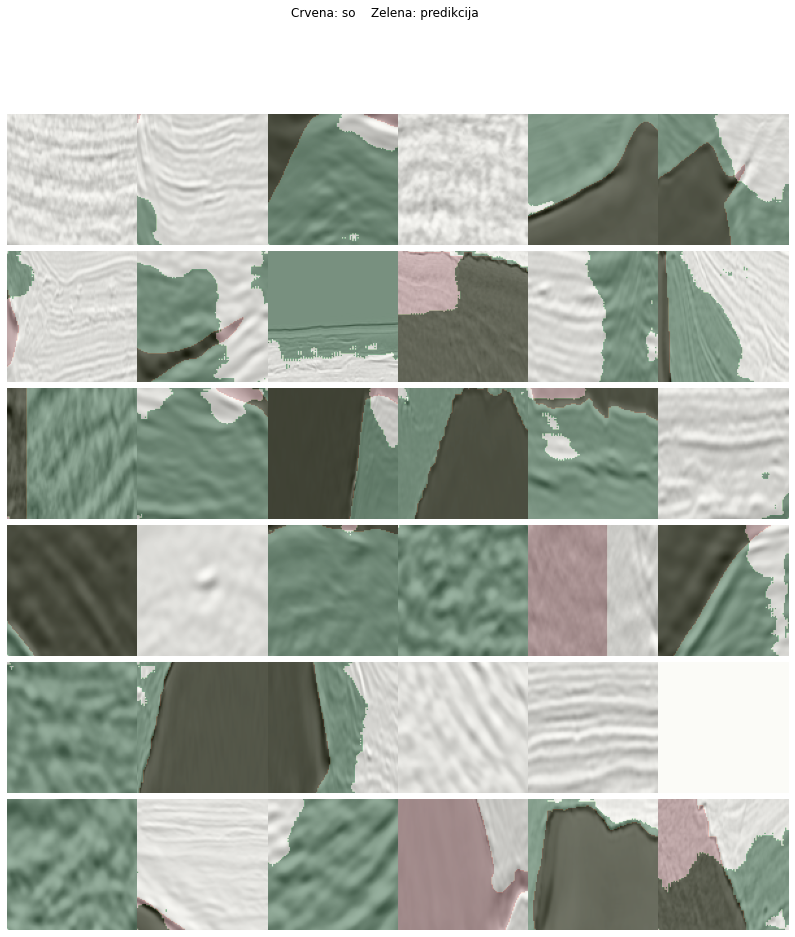

In [22]:
fig = plotValidationImages(x_validation, y_validation, np.round(pred_validation), k = 6, alpha1=0.4, alpha2=0.4)

In [23]:
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in

    true_objects = 2
    pred_objects = 2

    temp1 = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=([0,0.5,1], [0,0.5, 1]))

    intersection = temp1[0]

    area_true = np.histogram(labels,bins=[0,0.5,1])[0]
    area_pred = np.histogram(y_pred, bins=[0,0.5,1])[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Izračunava se unija
    union = area_true + area_pred - intersection
      
    # Isključuejmo pozadinu iz analize
    intersection = intersection[1:,1:]
    intersection[intersection == 0] = 1e-9
    
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Izračunava se vrednost IOU metrike
    iou = intersection / union

    # Pomoćna funkcija preciznosti
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # tačno pogodjeni objekti
        false_positives = np.sum(matches, axis=0) == 0  # pogrešno klasifikovani objekti
        false_negatives = np.sum(matches, axis=1) == 0  # objekti koji su pogrešno prepoznati kao negativni
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Prolazak kroz threshold iou vrednosti
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    # np.arrange vraca ravnomerno raspoređene vrednosti unutar intervala 0.5 i 1.0 sa korakom od 0.05
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [24]:
thresholds = np.linspace(0.3, 0.7, 31)
ious = np.array([iou_metric_batch(y_validation, np.int8(pred_validation > threshold)) for threshold in thresholds])
print(ious)

[0.15425  0.16225  0.166    0.174125 0.17975  0.189    0.1945   0.20575
 0.22025  0.22825  0.236    0.24325  0.264875 0.274875 0.28425  0.2865
 0.292125 0.297375 0.30725  0.312    0.31375  0.31825  0.323875 0.328375
 0.329875 0.335875 0.340375 0.3485   0.358375 0.36125  0.368375]


In [25]:
threshold_best_index = np.argmax(ious) 
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]
print("threshold best",threshold_best)
print("iou best",iou_best)

threshold best 0.7
iou best 0.36837500000000006


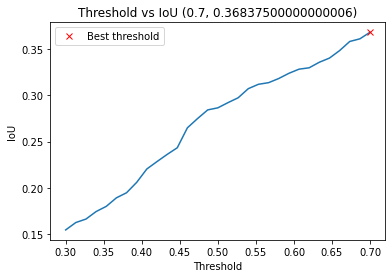

In [26]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

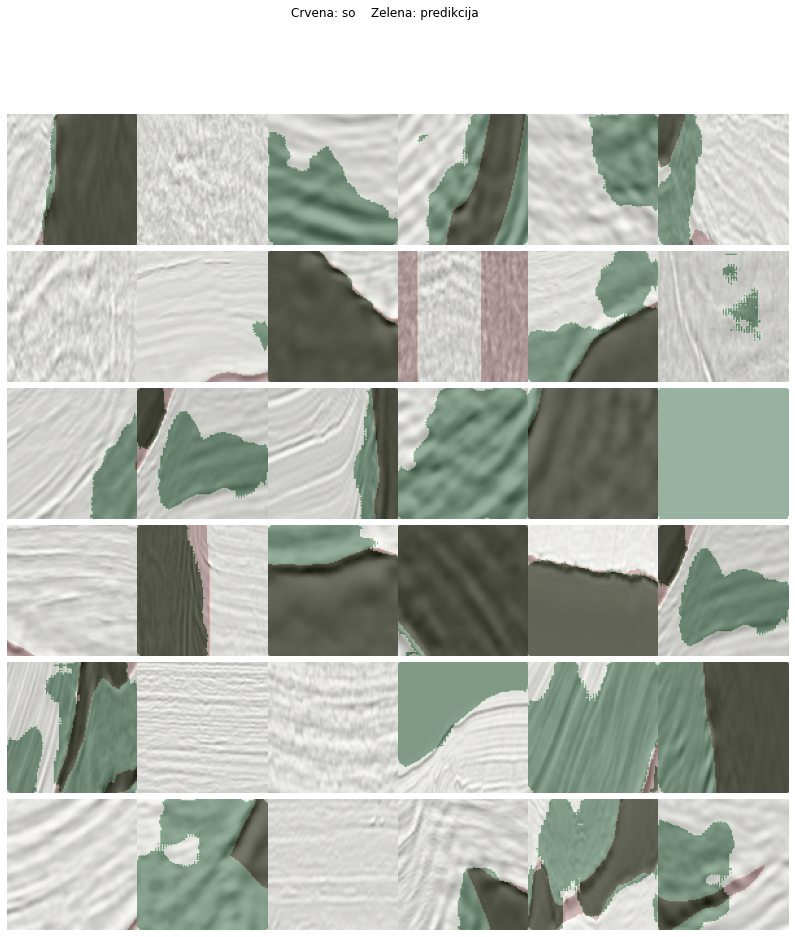

In [27]:
fig = plotValidationImages(x_validation, y_validation, np.int32(pred_validation > threshold_best), k = 6, alpha1=0.4, alpha2=0.4)